## Task 1

We have two populations Blue (privileged) and Red (unprivileged), with the Blue population being 9 times larger than the Red population.

The decision rule adopted:
1. In the Red group, half of the people will find the skills useful in future and half will not. Administrators randomly allocate 50% of people to training.
2. in the Blue group, 80% of people will find the training useful in future and 20% will not, although of course it is not known who will find it useful. The administrators have built a predictive model based on user behaviour in predicting for whom it will be useful and whom will not. The model has the following performance:

| Blue                     	| Will use XAI 	| Will not use XAI 	| Total 	|
|---------------------------|---------------|-------------------|-----------|
| Enrolled in training     	| 60           	| 5               	| 65    	|
| not enrolled in training 	| 20            | 15               	| 35    	|
| Total                    	| 80           	| 20               	| 100   	|


#### Demographic parity coefficient
$\frac{ P(\hat{Y} = 1 | C=r) } { P(\hat{Y} = 1 | C=b) } = \frac {\frac12} {\frac{65}{100}} \approx 0.769$

#### Equal opportunity coefficient
$\frac{P(\hat{Y} = 1 | C=r, Y=1)}{P(\hat{Y} = 1 | C=b, Y=1)} = \frac{\frac12}{ \frac{60}{80} } \approx 0.667$

#### Predictive rate parity coefficients
a) Positive predictive parity rate:

$\frac{P(Y = 1 | C=r, \hat{Y}=1)} {P(Y = 1 | C=b, \hat{Y}=1)} = \frac{\frac12}{\frac{60}{65}} \approx 0.542 $

b) Negative predictive parity rate:
$\frac{P(Y = 1 | C=r, \hat{Y}=0)} {P(Y = 1 | C=b, \hat{Y}=0)} = \frac{\frac12}{\frac{20}{35}} \approx 0.875 $


### (*) How can this decision rule be changed to improve its fairness?
We can use one predictive model on two groups, considering data imbalance, i.e. using over/under sampling

Alternatively, we can change the #1 decision rule, so that x% of people in the red group would get training (instead of the 50%).
Then, we would have following statistics:

#### Demographic parity coefficient
$\frac{ P'(\hat{Y} = 1 | C=r) } { P(\hat{Y} = 1 | C=b) } = \frac {x} {\frac{65}{100}}$

#### Equal opportunity coefficient
$\frac{P'(\hat{Y} = 1 | C=r, Y=1)}{P(\hat{Y} = 1 | C=b, Y=1)} = \frac{x}{ \frac{60}{80} }$

Predictive rate parity coefficients won't change.

We can choose the value for x to make the demographic parity coefficient/equal opportunity coefficient equal to 1, choosing
x=65% for the former case and x=75% for the latter.

Another option is to change the sensitivity of the model used for #2 decision rule (by changing threshold), so that its
demographic parity/equal opportunity/predictive rate parity coefficients is closer to 50%.

# Task 2

In this task, our goal is to train models on the [Give Me Some Credit dataset](https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset)
and analyze their fairness.

The protected variable in which we are interested in is age - or more precisely, a binary flag - whether someone is 'young' (under 35) or not.
Our concern is that young people might be discriminated and predicted to have a finanacial distress because of the age bias.

## Part 1 & 2 - Train a model and calculate its fairness coefficients:

In this part we train an **XGBoost** model with default hyperparameters (except max_depth=7).
Model evaluation:
| Metric     | XGBClassifier |
|------------|---------------|
| recall     | 0.188385      |
| precision  | 0.52988       |
| f1         | 0.277952      |
| accuracy   | 0.931056      |
| auc        | 0.839314      |


We then calculate its fairness coefficients:
| Coefficient             | Value |
|--------------------|-------|
| Statistical parity | 2.143 |
| Equal opportunity  | 1.081 |
| Predictive parity  | 0.876 |

We can see that our model is biased with regard to the statistical parity and predictive equality ratio.

![](images/2.png)

## Part 3 - Model with different hyperparameters

In this part we train a different model - also an XGBoost model, but now we constraint it even further - we set max_depth=2. In this way, we expect that the model will be forced to use very direct relationships of variables and will not base its predictions on the age variable.

| Metric     | XGBClassifier with max_depth=2 |
|------------|-------------------------------|
| recall     | 0.18508                        |
| precision  | 0.598473                       |
| f1         | 0.282726                       |
| accuracy   | 0.93385                        |
| auc        | 0.853459                       |


We then calculate its fairness coefficients:
| Coefficient             |Value |
|--------------------|-------|
| Statistical parity | 2.105 |
| Equal opportunity  | 1.066 |
| Predictive parity  | 0.842 |



We can see that the second model is also biased with regard to the statistical parity and predictive equality ratio, but the coefficients generally are closer to 1 (with the exception of predictive parity ratio) when comparing with the first model. Our prediction that a model with a smaller maximum tree depth would be less biased proved true (at least to some degree).

![](images/3.png)

## Part 4 - Bias mitigation techniques

In this part we apply different bias mitigation techniques:
1. we exclude the `age` variable from the training data,
2. we combine the previous method with the use of reweighting

We observe that in this case, these bias mitigation techniques helped to make the model more fair: simply excluding the `age` variable made all fairness coefficients closer to 1, and additionaly applying reweighting further improved most of the coefficients.
However, the bias is still there, as the statistical parity ratio for the 2nd method is as big as 1.619.

The results are shown here:

![](images/4.png)

## Part 5 - Model performence vs fairness

In this part we compare the quality of the models with their fairness coefficients.

| Metric                                    | XGBClassifier | XGBClassifier with max_depth=2 | XGBClassifier without the protected attribute | XGBClassifier with Reweight mitigation |
|-------------------------------------------|---------------|-------------------------------|----------------------------------------------|---------------------------------------|
| recall                                    | 0.1884        | 0.1851                        | 0.1884                                       | 0.1728                                |
| precision                                 | 0.5299        | 0.5985                        | 0.5377                                       | 0.5244                                |
| f1                                        | 0.2780        | 0.2827                        | 0.2790                                       | 0.2599                                |
| accuracy                                  | 0.9311        | 0.9339                        | 0.9314                                       | 0.9307                                |
| auc                                       | 0.8393        | 0.8535                        | 0.8350                                       | 0.8336                                |

Interestingly, we can see that decreasing max_depth actually improved the model quality and decreased the bias at the same time.

In the similar way, dropping the `age` variable has also slightly improved the model precision (without changing recall) and increased the model fairness.

Model using reweightning was the most fair model, and it is also the worst one when it comes to the performance, as its recall and predcision slightly decreased.

## Appendix

In [198]:
from matplotlib import pyplot as plt
import pandas as pd
import xgboost
import sklearn
from sklearn.linear_model import LogisticRegression
import dalex as dx
import seaborn as sns

from dalex.fairness import resample, reweight, roc_pivot
from copy import copy

from sklearn.model_selection import train_test_split

In [39]:
target_col  = 'SeriousDlqin2yrs'

df = pd.read_csv('cs-training.csv', index_col=0)
df = df.dropna()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [340]:
df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,1.202690e+05,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000
mean,0.069486,5.899873,51.289792,0.381769,26.598777,6.670221e+03,8.758475,0.211925,1.054519,0.187829,0.851832
std,0.254280,257.040685,14.426684,3.499234,424.446457,1.438467e+04,5.172835,3.465276,1.149273,3.447901,1.148391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.035084,40.000000,0.000000,0.143388,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.177282,51.000000,0.000000,0.296023,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.579428,61.000000,0.000000,0.482559,8.249000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,50708.000000,103.000000,98.000000,61106.500000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [40]:
X = df.drop([target_col], axis=1)
y = df[[target_col]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [325]:
model = xgboost.XGBClassifier(max_depth=7)

model.fit(X_train, y_train)

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Fairness analysis

In [326]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]
    
explainer = dx.Explainer(model, X_test, y_test, predict_function=pf_xgboost_classifier_categorical)

Preparation of a new explainer is initiated

  -> data              : 30068 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 30068 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x13b8dfdc0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 9.7e-05, mean = 0.0672, max = 0.976
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.963, mean = 0.00326, max = 1.0
  -> model_info        : package xgboost

A new explainer has been created!


/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_

In [327]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.188385,0.52988,0.277952,0.931056,0.839314


Calculating ceteris paribus:   0%|          | 0/10 [00:00<?, ?it/s]/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/l

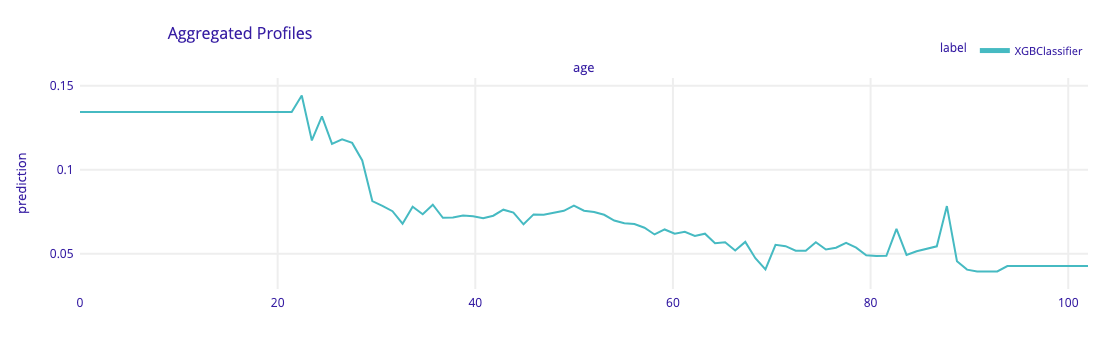

In [328]:
profiles = explainer.model_profile()
profiles.plot(variables=["age"])

In [329]:
AGE_THRESHOLD = 35
protected_variable = X_test["age"].apply(lambda x: "old" if x > AGE_THRESHOLD else "young")
privileged_group = "old"

fobject = explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

fobject.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'old'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
            TPR       ACC       PPV  FPR       STP
young  1.081081  0.949893  0.876138  2.6  2.142857


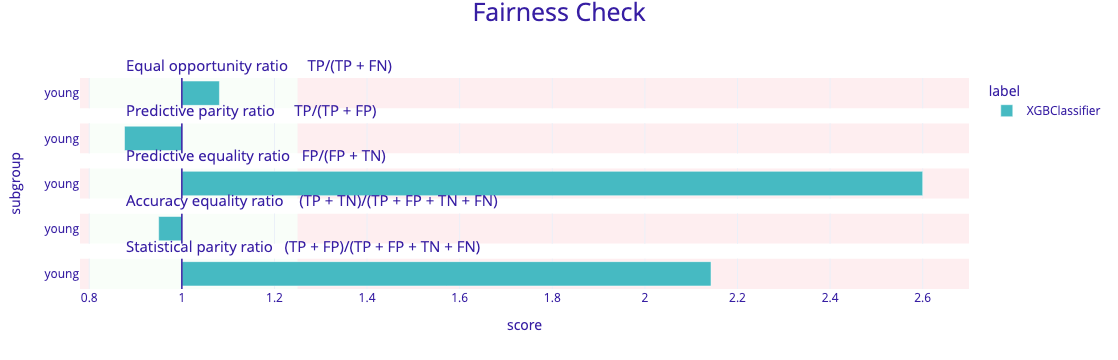

In [330]:
fobject.plot()

### Model with different hyperparameters

In [338]:
model_different = xgboost.XGBClassifier(
    max_depth=2
)
model_different.fit(X_train, y_train)

explainer_different = dx.Explainer(
    model_different, 
    X_test, 
    y_test, 
    label='XGBClassifier with max_depth=2',
    predict_function=pf_xgboost_classifier_categorical,
    verbose=False
)

explainer_different.model_performance()

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_

,recall,precision,f1,accuracy,auc
XGBClassifier with max_depth=2,0.18508,0.598473,0.282726,0.93385,0.853459


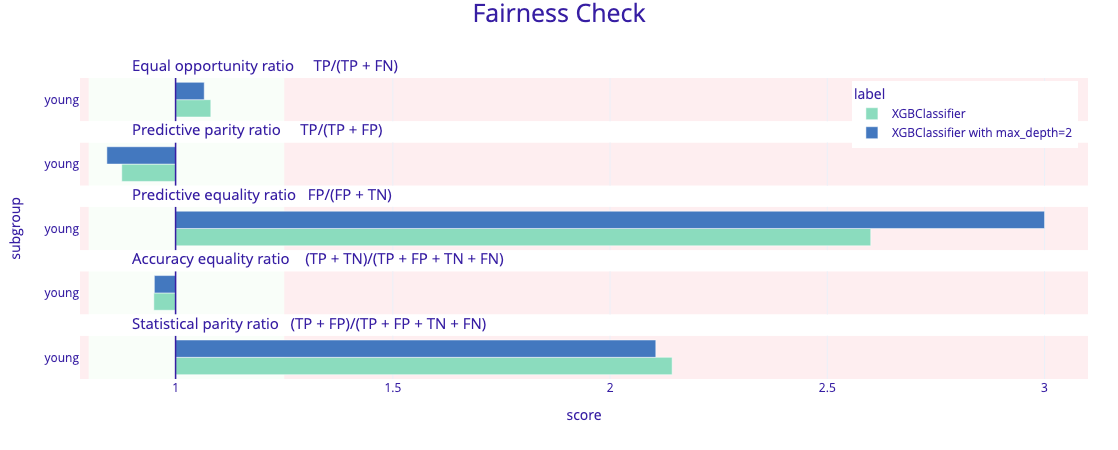

In [339]:
fobject_different = explainer_different.model_fairness(
    protected_variable, 
    privileged_group
)

fobject.plot(fobject_different, show=False).\
    update_layout(autosize=False, width=800, height=450, legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))

### Bias mitigation technique

#### Dropping dependent variable

In [333]:
X_train_without_prot, X_test_without_prot = X_train.drop("age", axis=1), X_test.drop("age", axis=1)

model_without_prot = copy(model)
model_without_prot.fit(X_train_without_prot, y_train)

explainer_without_prot = dx.Explainer(
    model_without_prot, 
    X_test_without_prot, 
    y_test,
    predict_function=pf_xgboost_classifier_categorical,
    label="XGBClassifier without the protected attribute",
    verbose=False
)

fobject_without_prot = explainer_without_prot.model_fairness(protected_variable, privileged_group)

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_

#### Resample

In [335]:
protected_variable_train = X_train["age"].apply(lambda x: "old" if x > AGE_THRESHOLD else "young")

# reweight
sample_weight = reweight(
    protected_variable_train, 
    y_train, 
    verbose=False
)
model_reweight = copy(model_without_prot)
model_reweight.fit(X_train_without_prot, y_train, sample_weight=sample_weight)
explainer_reweight = dx.Explainer(
    model_reweight, 
    X_test_without_prot, 
    y_test, 
    label='XGBClassifier with Reweight mitigation',
    verbose=False
)
fobject_reweight = explainer_reweight.model_fairness(
    protected_variable, 
    privileged_group
)

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:335: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:338: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:359: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/michal.janik/studia/XAI/.env/lib/python3.9/site-packages/xgboost/data.py:384: FutureWarning:

is_

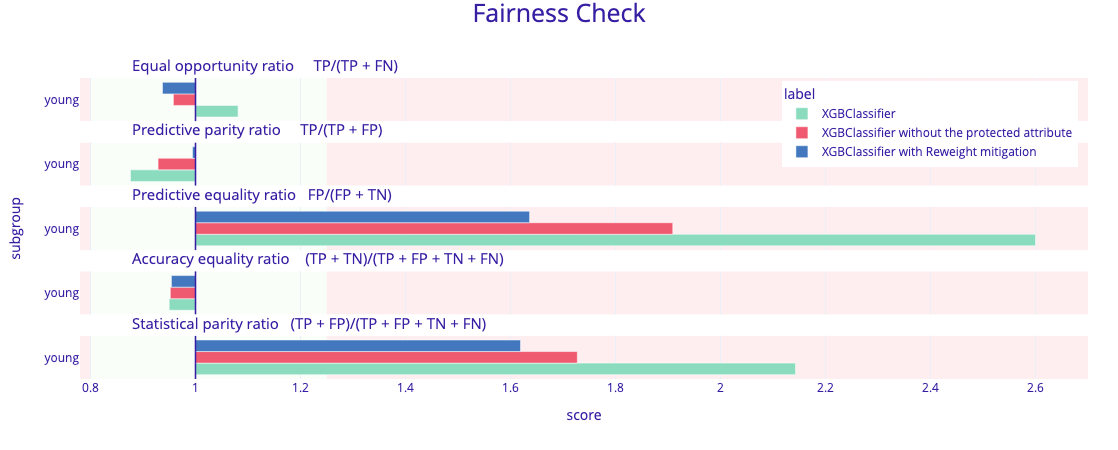

In [336]:
fobject.plot([fobject_without_prot, fobject_reweight], show=False).\
    update_layout(autosize=False, width=800, height=450, legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99))


In [337]:
pd.concat([
    explainer.model_performance().result,
    explainer_different.model_performance().result,
    explainer_without_prot.model_performance().result, 
    explainer_reweight.model_performance().result,
], axis=0)

,recall,precision,f1,accuracy,auc
XGBClassifier,0.188385,0.529880,0.277952,0.931056,0.839314
XGBClassifier with max_depth=2,0.185080,0.598473,0.282726,0.933850,0.853459
XGBClassifier without the protected attribute,0.188385,0.537736,0.279021,0.931422,0.835006
XGBClassifier with Reweight mitigation,0.172805,0.524355,0.259943,0.930690,0.833640
